In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk 
import psycopg2 as psy
import seaborn as sns


from IPython.core.display import Image, HTML


%matplotlib inline

The aim of the project is to understand the distribution, characteristics, and components of individual airports operations that are leading to delays.

1. Organize and store  data so that it can be easily understood after the analysis is done
2. Mine and refine the data to uncover its basic attributes and characteristics
3. Use PCA to uncover the core components of operations related to delays
4. Transfer database to AWS to make the data and findings universally accessible




Load our csv files into tables

In [2]:
ls assets

Airport_operations.csv     airports.csv
airport_cancellations.csv


In [3]:

from sqlalchemy import create_engine
import pandas as pd

engine = create_engine('postgresql://localhost:5432')
pd.read_sql("SELECT * FROM information_schema.tables LIMIT 3;", engine)



table_catalog table_schema    table_name  table_type  \
0  egorkharakozov       public     evictions  BASE TABLE   
1  egorkharakozov   pg_catalog  pg_statistic  BASE TABLE   
2  egorkharakozov   pg_catalog       pg_type  BASE TABLE   

  self_referencing_column_name reference_generation user_defined_type_catalog  \
0                         None                 None                      None   
1                         None                 None                      None   
2                         None                 None                      None   

  user_defined_type_schema user_defined_type_name is_insertable_into is_typed  \
0                     None                   None                YES       NO   
1                     None                   None                YES       NO   
2                     None                   None                YES       NO   

  commit_action  
0          None  
1          None  
2          None

In [4]:
def load_to_sql(name):
    df = pd.read_csv(path.format(name), encoding='latin1')
    df.to_sql(name.lower(), engine, flavor='postgres', if_exists='replace')
    print "done", name

path = "assets/{}.csv"


load_to_sql('Airport_operations')
load_to_sql('airports')
load_to_sql('airport_cancellations')

done Airport_operations
done airports
done airport_cancellations


Join airport_cancellations.csv and airports.csv into one table

In [5]:
%load_ext sql

/Users/egorkharakozov/anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/egorkharakozov/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [6]:
%sql postgresql://localhost:5432

'Connected: None@None'

In [7]:
%%sql

select * from airport_operations limit 3

3 rows affected.


[(0L, u'ABQ', 2004L, 53971L, 53818L, 0.803, 0.7809, 0.7921, 10.38, 9.89, 2.43, 12.1, 2.46, 0.83, 2.55, 10.87),
 (1L, u'ABQ', 2005L, 51829L, 51877L, 0.814, 0.7922, 0.8001, 9.6, 9.79, 2.29, 11.2, 2.26, 0.89, 2.34, 10.24),
 (2L, u'ABQ', 2006L, 49682L, 51199L, 0.7983, 0.7756, 0.7746, 10.84, 9.89, 2.16, 12.33, 2.12, 0.84, 2.66, 11.82)]

In [8]:
%%sql

select * from airports limit 3

3 rows affected.


[(0L, 3443.0, u'STX', u'HENRY E ROHLSEN', u"Henry E Rohlsen Int'l Airport", u'Airport', u'ASO', u'-VIRGIN ISLANDS-', u'CHRISTIANSTED', u'VI', u'Public Use', 17.701556, -64.801722, u'Yes'),
 (1L, 5088.0, u'X64', u'PATILLAS', None, u'Airport', u'ASO', u'#NAME?', u'PATILLAS', u'PR', u'Public Use', 17.982189, -66.01933, u'No'),
 (2L, 2886.0, u'PSE', u'MERCEDITA', u'Aeropuerto Mercedita', u'Airport', u'ASO', u'#NAME?', u'PONCE', u'PR', u'Public Use', 18.008306, -66.563028, u'Yes')]

In [9]:
%%sql

select * from airport_cancellations limit 3

3 rows affected.


[(0L, u'ABQ', 2004.0, 242.0, 235.0, 71.0, 46.0),
 (1L, u'ABQ', 2005.0, 221.0, 190.0, 61.0, 33.0),
 (2L, u'ABQ', 2006.0, 392.0, 329.0, 71.0, 124.0)]

In [10]:
%%sql 
select * from airport_operations as ap, airport_cancellations as ac, airports as a

where ac."Airport" = a."LocID" 
and ap."airport" = ac."Airport" 
and ap."year" = ac."Year"


799 rows affected.


[(744L, u'SJU', 2014L, 43671L, 42965L, 0.8056, 0.7784, 0.7815, 11.71, 12.89, 1.88, 13.13, 1.81, 1.0, 2.93, 12.79, 727L, u'SJU', 2014.0, 280.0, 241.0, 72.0, 31.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (743L, u'SJU', 2013L, 42902L, 42175L, 0.8058, 0.7808, 0.784, 12.31, 13.56, 2.2, 13.52, 1.78, 1.41, 2.86, 12.96, 726L, u'SJU', 2013.0, 127.0, 94.0, 65.0, 64.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (742L, u'SJU', 2012L, 44716L, 43985L, 0.8417, 0.8228, 0.8181, 9.55, 13.15, 1.82, 10.55, 1.41, 1.33, 2.89, 10.64, 725L, u'SJU', 2012.0, 174.0, 141.0, 62.0, 41.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (741L, u'SJU', 2011L, 42803L, 42401L, 0.8179, 0.7934, 0.7899, 10.86, 13.23, 1.96, 12.07, 1.45, 1.57, 3.67, 12.28, 724L, u'SJU', 2011.0, 240.0, 201.0, 101.0, 55.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (740L, u'SJU', 2010L, 47314L, 45781L, 0.7967, 0.7815, 0.7719, 12.21, 13.04, 1.39, 13.0, 1.65, 1.32, 3.53, 13.4, 723L, u'SJU', 2010.0, 258.0, 207.0, 82.0, 45.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (739L, u'SJU', 2009L, 48418L, 46678L, 0.8168, 0.8015, 0.7999, 11.44, 13.29, 1.43, 12.28, 1.22, 0.95, 2.88, 11.77, 722L, u'SJU', 2009.0, 199.0, 159.0, 57.0, 58.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (738L, u'SJU', 2008L, 44493L, 43448L, 0.8004, 0.781, 0.7533, 12.54, 14.22, 1.85, 13.59, 1.64, 1.25, 3.75, 15.18, 721L, u'SJU', 2008.0, 238.0, 197.0, 78.0, 29.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (737L, u'SJU', 2007L, 47987L, 47246L, 0.8014, 0.7522, 0.7414, 12.53, 15.22, 3.16, 14.97, 1.55, 1.71, 4.09, 16.31, 720L, u'SJU', 2007.0, 307.0, 278.0, 70.0, 42.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (736L, u'SJU', 2006L, 55707L, 52948L, 0.8054, 0.7446, 0.7611, 11.61, 15.75, 4.28, 14.34, 1.73, 1.29, 4.19, 14.17, 719L, u'SJU', 2006.0, 257.0, 233.0, 63.0, 44.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (735L, u'SJU', 2005L, 57736L, 54870L, 0.7789, 0.7464, 0.7604, 12.74, 14.14, 3.03, 14.43, 1.63, 1.36, 4.04, 14.65, 718L, u'SJU', 2005.0, 315.0, 282.0, 64.0, 36.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (734L, u'SJU', 2004L, 60371L, 56735L, 0.8019, 0.7794, 0.7984, 11.19, 13.84, 2.27, 12.43, 1.88, 0.79, 3.39, 12.28, 717L, u'SJU', 2004.0, 330.0, 289.0, 55.0, 28.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Feder

The above should be a good table to work with for this analysis. It is an inner join on the three tables but there is not much data lost in terms of cancellation data which is ultimately what we are analyzing and targeting here. The rowcounts were as follows:

            airports	5176
        cancellations	805
            operations	841

The resulting joined table ends up with 799 rows and since I join in the order
operatins --> cancellations --> airports
I know I will have the majority of the cancellation data captured.

Because there are a lot of features but not a big number of samples, I will pull this into a panda frame and then use pandas to write to a new table in the database to avoid having to declare the type of each feature.

In [11]:
sql = """
select * from airport_operations as ap, airport_cancellations as ac, airports as a

where ac."Airport" = a."LocID" 
and ap."airport" = ac."Airport" 
and ap."year" = ac."Year"
"""

In [12]:
df = pd.read_sql(sql, engine)

df.head(2)

index airport  year  departures for metric computation  \
0    744     SJU  2014                              43671   
1    743     SJU  2013                              42902   

   arrivals for metric computation  percent on-time gate departures  \
0                            42965                           0.8056   
1                            42175                           0.8058   

   percent on-time airport departures  percent on-time gate arrivals  \
0                              0.7784                         0.7815   
1                              0.7808                         0.7840   

   average_gate_departure_delay  average_taxi_out_time  \
0                         11.71                  12.89   
1                         12.31                  13.56   

            ...                                           ALIAS  \
0           ...             Aeropuerto Int'l Luis Muï¿½oz Marin   
1           ...             Aeropuerto Int'l Luis Muï¿½oz Marin   

   Facility Type  FAA REGION  COUNTY      CITY  STATE                 AP Type  \
0        Airport         ASO  #NAME?  SAN JUAN     PR  Federalized/Commercial   
1        Airport         ASO  #NAME?  SAN JUAN     PR  Federalized/Commercial   

    Latitude  Longitude  Boundary Data Available  
0  18.439295 -66.002004                      Yes  
1  18.439295 -66.002004                      Yes  

[2 rows x 37 columns]

In [13]:

df.to_sql("all_airport_data", engine, flavor='postgres', if_exists='replace')

In [14]:
df.describe()

index         year  departures for metric computation  \
count  799.000000   799.000000                         799.000000   
mean   409.274093  2009.016270                      113471.568210   
std    238.271793     3.150126                       98059.144667   
min      0.000000  2004.000000                         731.000000   
25%    199.500000  2006.000000                       42064.000000   
50%    410.000000  2009.000000                       79489.000000   
75%    613.500000  2012.000000                      166469.500000   
max    829.000000  2014.000000                      491826.000000   

       arrivals for metric computation  percent on-time gate departures  \
count                       799.000000                       799.000000   
mean                     113003.959950                         0.779123   
std                       97705.308115                         0.052279   
min                         717.000000                         0.529900   
25%                       42006.500000                         0.753100   
50%                       79750.000000                         0.784100   
75%                      165560.500000                         0.810700   
max                      486799.000000                         0.909700   

       percent on-time airport departures  percent on-time gate arrivals  \
count                          799.000000                     799.000000   
mean                             0.726958                       0.766864   
std                              0.076027                       0.050502   
min                              0.380800                       0.513600   
25%                              0.691800                       0.742150   
50%                              0.740200                       0.770500   
75%                              0.773700                       0.797600   
max                              0.897400                       0.880300   

       average_gate_departure_delay  average_taxi_out_time  \
count                    799.000000             799.000000   
mean                      12.890250              13.872879   
std                        3.036474               3.806217   
min                        5.350000               7.240000   
25%                       10.830000              11.475000   
50%                       12.540000              12.940000   
75%                       14.620000              15.745000   
max                       25.840000              35.760000   

       average taxi out delay     ...           index         Year  \
count              799.000000     ...      799.000000   799.000000   
mean                 3.683292     ...      399.979975  2009.016270   
std                  2.337325     ...      232.145959     3.150126   
min                  0.100000     ...        0.000000  2004.000000   
25%                  2.300000     ...      199.500000  2006.000000   
50%                  3.050000     ...      399.000000  2009.000000   
75%                  4.220000     ...      598.500000  2012.000000   
max                 18.940000     ...      804.000000  2014.000000   

       Departure Cancellations  Arrival Cancellations  Departure Diversions  \
count               799.000000             799.000000            799.000000   
mean               1299.314143            1341.068836            174.250313   
std                1840.877193            1980.459892            172.638408   
min                   0.000000               0.000000              0.000000   
25%                 349.000000             314.500000             62.000000   
50%                 670.000000             653.000000            111.000000   
75%                1483.500000            1542.000000            237.000000   
max               16618.000000           17571.000000           1064.000000   

       Arrival Diversions        index          Key    Latitude   Longitude  
count          799.000000   799.000000   799.0000

In [15]:
df.drop("index", axis = 1, inplace = 1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 34 columns):
airport                               799 non-null object
year                                  799 non-null int64
departures for metric computation     799 non-null int64
arrivals for metric computation       799 non-null int64
percent on-time gate departures       799 non-null float64
percent on-time airport departures    799 non-null float64
percent on-time gate arrivals         799 non-null float64
average_gate_departure_delay          799 non-null float64
average_taxi_out_time                 799 non-null float64
average taxi out delay                799 non-null float64
average airport departure delay       799 non-null float64
average airborne delay                799 non-null float64
average taxi in delay                 799 non-null float64
average block delay                   799 non-null float64
average gate arrival delay            799 non-null float64
Airport          

In [17]:
for col in df.columns:
    print col, len(df[col].unique())

airport 74
year 11
departures for metric computation 795
arrivals for metric computation 799
percent on-time gate departures 620
percent on-time airport departures 686
percent on-time gate arrivals 630
average_gate_departure_delay 561
average_taxi_out_time 568
average taxi out delay 419
average airport departure delay 599
average airborne delay 348
average taxi in delay 270
average block delay 326
average gate arrival delay 554
Airport 74
Year 11
Departure Cancellations 672
Arrival Cancellations 655
Departure Diversions 353
Arrival Diversions 340
Key 74
LocID 74
AP_NAME 74
ALIAS 74
Facility Type 1
FAA REGION 9
COUNTY 63
CITY 69
STATE 36
AP Type 2
Latitude 74
Longitude 74
Boundary Data Available 1


In [18]:
catcols = df.columns[df.dtypes==object].drop(["Airport", "LocID", "airport", "AP_NAME", "ALIAS", "Facility Type"])

catcols

Index([u'FAA REGION', u'COUNTY', u'CITY', u'STATE', u'AP Type',
       u'Boundary Data Available'],
      dtype='object')

In [19]:
target = df.airport

target.head(2)

0    SJU
1    SJU
Name: airport, dtype: object

In [20]:
df.pivot_table(["Departure Cancellations", "Arrival Cancellations"], index = "year").plot(figsize = (10,8));
plt.show()

In [21]:
df.pivot_table(["Departure Diversions", "Arrival Diversions"], index = "year").plot(figsize = (10,8));
plt.show()

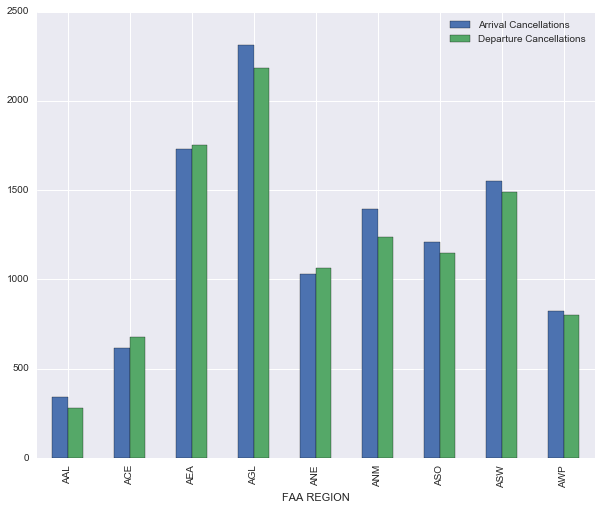

In [22]:
df.pivot_table(["Departure Cancellations", "Arrival Cancellations"], 
               index = "FAA REGION").plot(kind = "bar", figsize = (10,8));
plt.show()

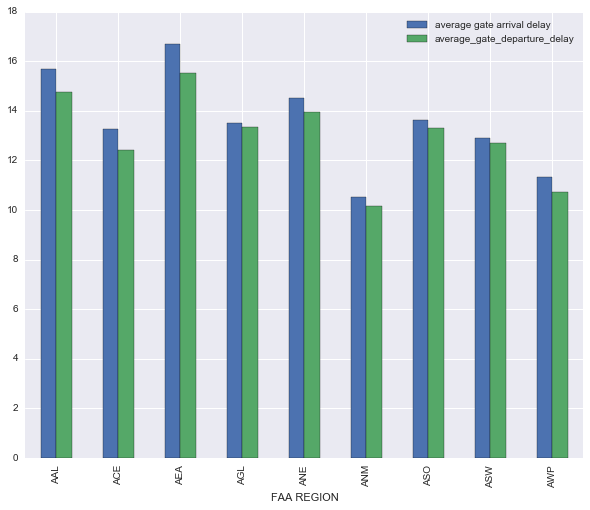

In [23]:
df.pivot_table(["average_gate_departure_delay", "average gate arrival delay"], 
               index = "FAA REGION").plot(kind = "bar", figsize = (10,8));
plt.show()

In [24]:
num_cols = df.columns[df.dtypes=="float64"].drop(["Year", "Key", "Latitude", "Longitude"])
num_cols

Index([u'percent on-time gate departures',
       u'percent on-time airport departures', u'percent on-time gate arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average taxi out delay', u'average airport departure delay',
       u'average airborne delay', u'average taxi in delay',
       u'average block delay', u'average gate arrival delay',
       u'Departure Cancellations', u'Arrival Cancellations',
       u'Departure Diversions', u'Arrival Diversions'],
      dtype='object')

In [25]:
num_cols | ["FAA REGION"]

Index([             u'Arrival Cancellations',
                       u'Arrival Diversions',
                  u'Departure Cancellations',
                     u'Departure Diversions',
                               u'FAA REGION',
                   u'average airborne delay',
          u'average airport departure delay',
                      u'average block delay',
               u'average gate arrival delay',
                    u'average taxi in delay',
                   u'average taxi out delay',
             u'average_gate_departure_delay',
                    u'average_taxi_out_time',
       u'percent on-time airport departures',
            u'percent on-time gate arrivals',
          u'percent on-time gate departures'],
      dtype='object')

In [26]:
#going to grab the columns by 3 randomly and do pairplots by region just to explore some of the relationships

np.random.shuffle(list(num_cols))
num_cols

Index([u'percent on-time gate departures',
       u'percent on-time airport departures', u'percent on-time gate arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average taxi out delay', u'average airport departure delay',
       u'average airborne delay', u'average taxi in delay',
       u'average block delay', u'average gate arrival delay',
       u'Departure Cancellations', u'Arrival Cancellations',
       u'Departure Diversions', u'Arrival Diversions'],
      dtype='object')

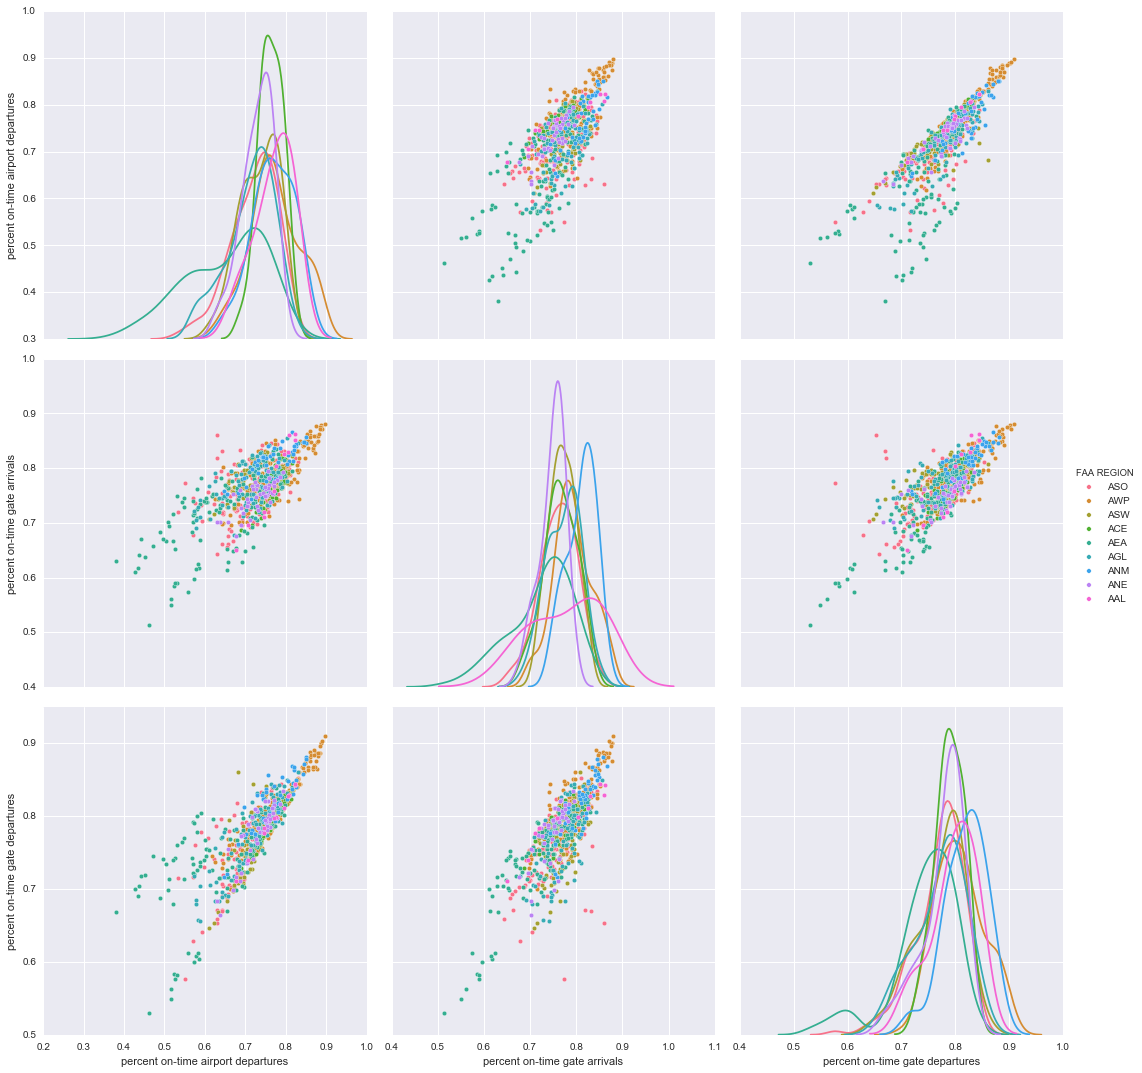

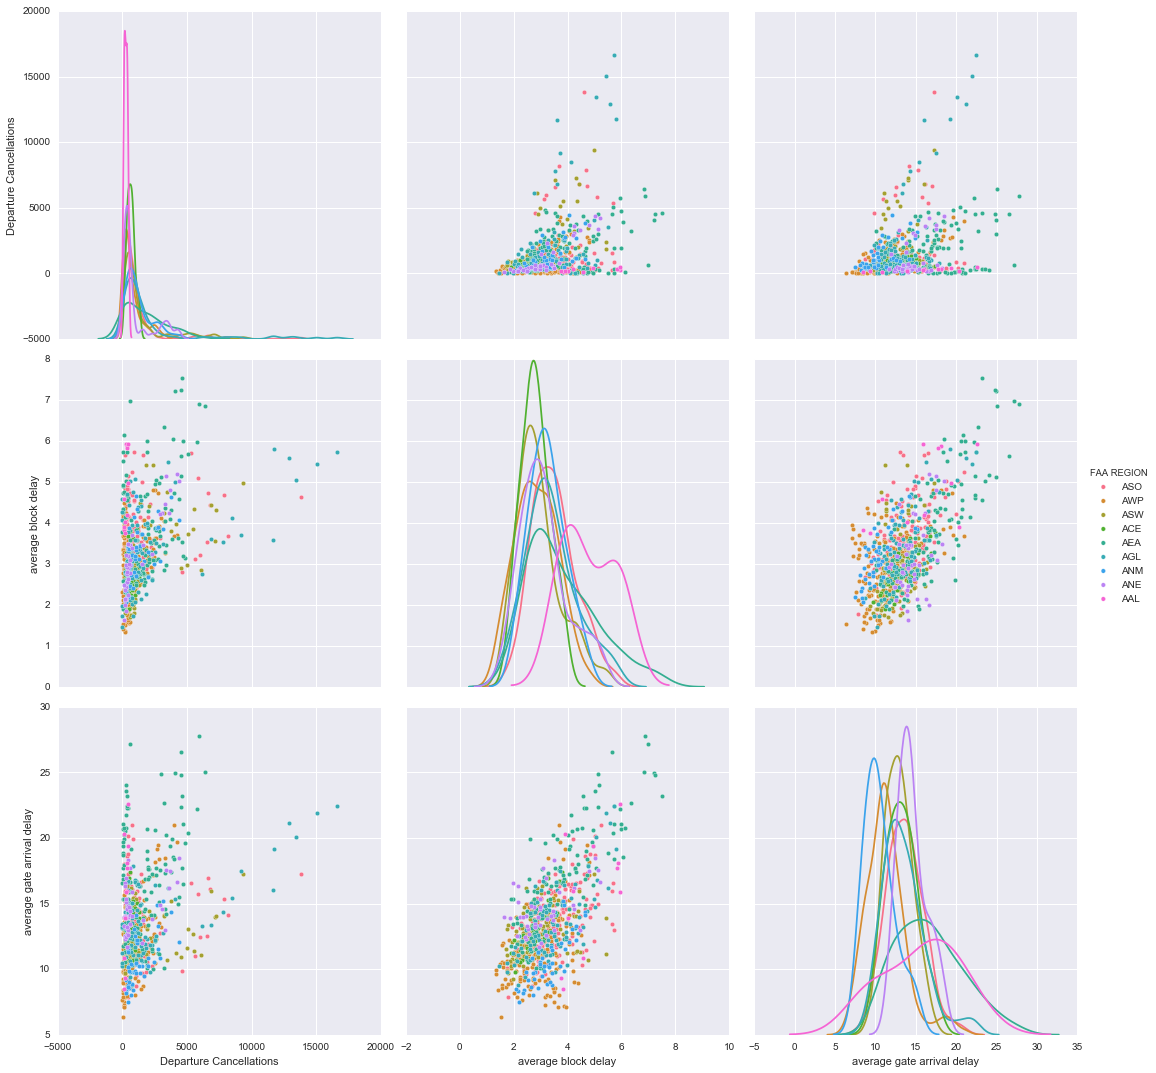

In [27]:

sns.pairplot(df[num_cols[:3] | ["FAA REGION"]], 
             kind = "scatter", diag_kind = "kde", hue = "FAA REGION",size = 5)

plt.show()
sns.pairplot(df[num_cols[3:6] | ["FAA REGION"]], 
             kind = "scatter", diag_kind = "kde", hue = "FAA REGION",size = 5)

plt.show()

sns.pairplot(df[num_cols[6:9] | ["FAA REGION"]], 
             kind = "scatter", diag_kind = "kde", hue = "FAA REGION",size = 5)
plt.show()

sns.pairplot(df[num_cols[9:12] | ["FAA REGION"]], 
             kind = "scatter", diag_kind = "kde", hue = "FAA REGION",size = 5)
plt.show()

sns.pairplot(df[num_cols[12:15] | ["FAA REGION"]], 
             kind = "scatter", diag_kind = "kde", hue = "FAA REGION",size = 5)
plt.show()

Obviosly this is not particularly scientific and we are not explofing all of the possible relationships given that there are so many variables, however looking at the diagonal kde plots it does look like most of the variables are more or less normally distributed which would lend itself to normalization when I will do PCA a little later.
The scatter plots show both some of the clustering present by region and also the prevalence of pretty strong linear relationships (correlations) between the variables. Again, this will be useful for PCA since there is a good chance we will have good success reducing the number of features here.

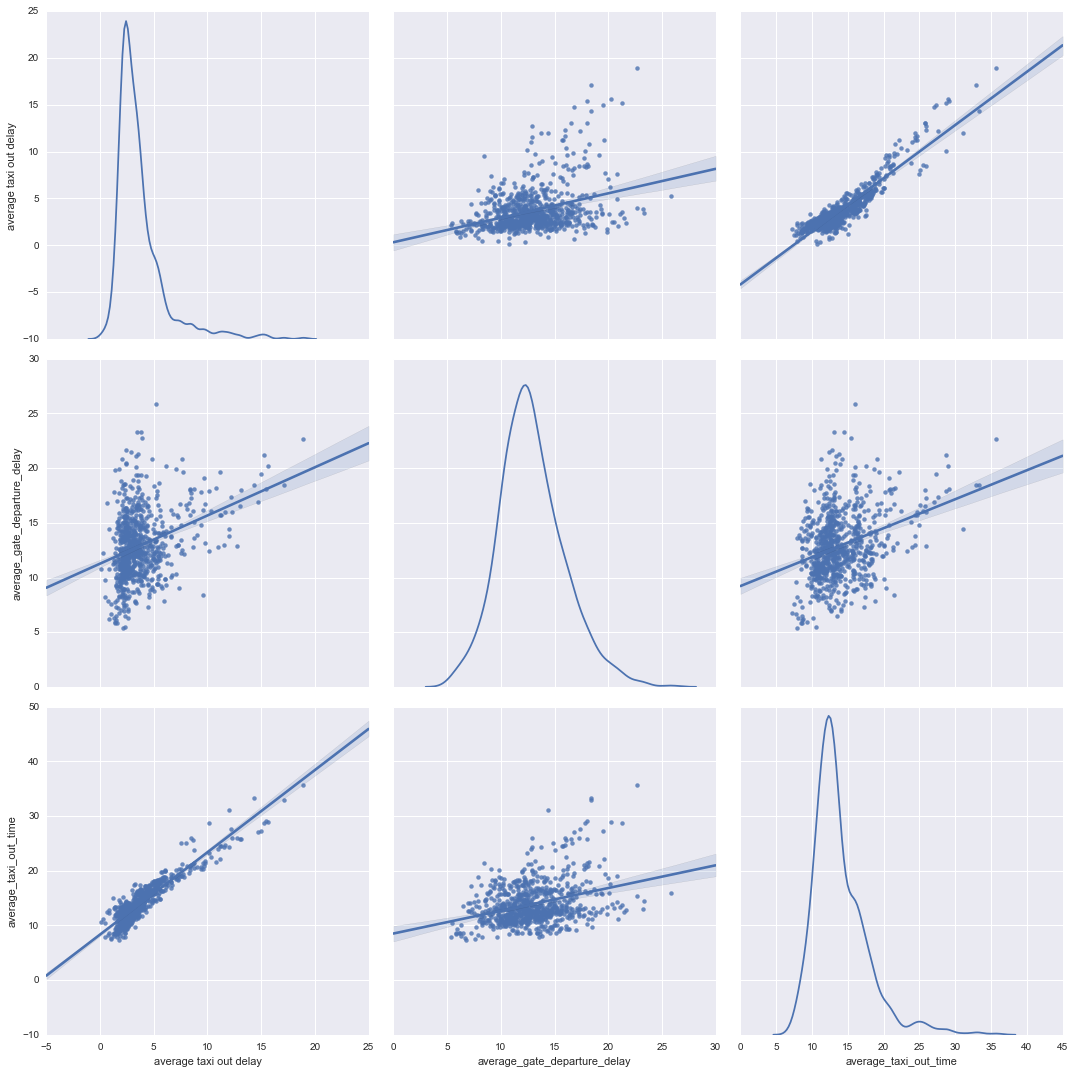

In [28]:

sns.pairplot(df[num_cols[:3] | ["FAA REGION"]], 
             kind = "reg", diag_kind = "kde",size = 5)

plt.show()
sns.pairplot(df[num_cols[3:6] | ["FAA REGION"]], 
             kind = "reg", diag_kind = "kde",size = 5)

plt.show()

sns.pairplot(df[num_cols[6:9] | ["FAA REGION"]], 
             kind = "reg", diag_kind = "kde",size = 5)
plt.show()

sns.pairplot(df[num_cols[9:12] | ["FAA REGION"]], 
             kind = "reg", diag_kind = "kde",size = 5)
plt.show()

sns.pairplot(df[num_cols[12:15] | ["FAA REGION"]], 
             kind = "reg", diag_kind = "kde",size = 5)
plt.show()

Redoing this plotting without the hue set to region, shows that the variables are close to normally distributed and do exhibit some strong relationships in some cases. 

In [29]:
sns.set_style("white")

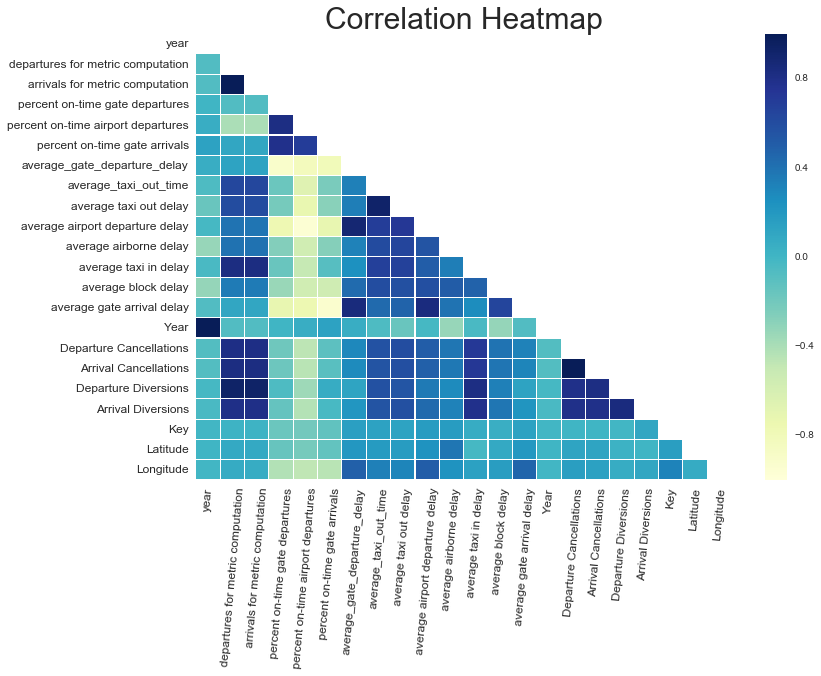

In [30]:
corrmat = df.corr()


mask = np.tri(len(corrmat)).T

fig = plt.figure(figsize = (12,8))
axes = fig.gca()

axes.tick_params(labelsize = 12)




sns.heatmap(corrmat, cmap = "YlGnBu", linecolor= "white", linewidths=".1", mask = mask);

plt.xticks(rotation = 85);

axes.set_title("Correlation Heatmap", size = 30)


In [31]:
#lets take a closer look at just how correlated all of the delay metrics are

delay_cols = df.columns[df.columns.str.contains("delay") | df.columns.str.contains("time")]
delay_cols


Index([u'percent on-time gate departures',
       u'percent on-time airport departures', u'percent on-time gate arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average taxi out delay', u'average airport departure delay',
       u'average airborne delay', u'average taxi in delay',
       u'average block delay', u'average gate arrival delay'],
      dtype='object')

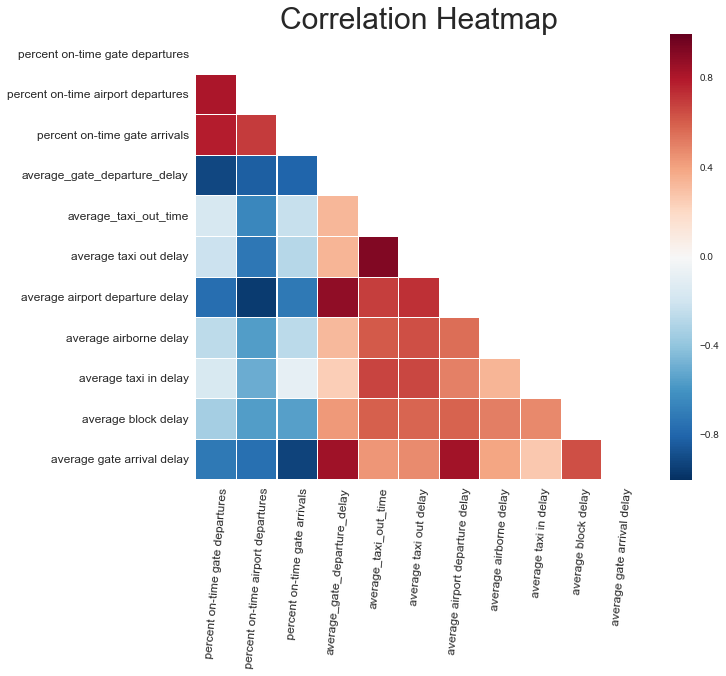

In [32]:
corrmat = df[delay_cols].corr()

mask = np.tri(len(corrmat)).T

fig = plt.figure(figsize = (10,8))
axes = fig.gca()

axes.tick_params(labelsize = 12)

sns.heatmap(corrmat,linecolor= "white", linewidths=".1", mask = mask);

plt.xticks(rotation = 85);

axes.set_title("Correlation Heatmap", size = 30)


In [33]:
#Obviosly some strong correlations there.

#Now I am going to grab some data for Tableau to visualize delay times by latitude and longtitude

df[num_cols | ["Latitude", "Longitude", "Airport", "AP_NAME"]].to_excel("project7.xlsx")

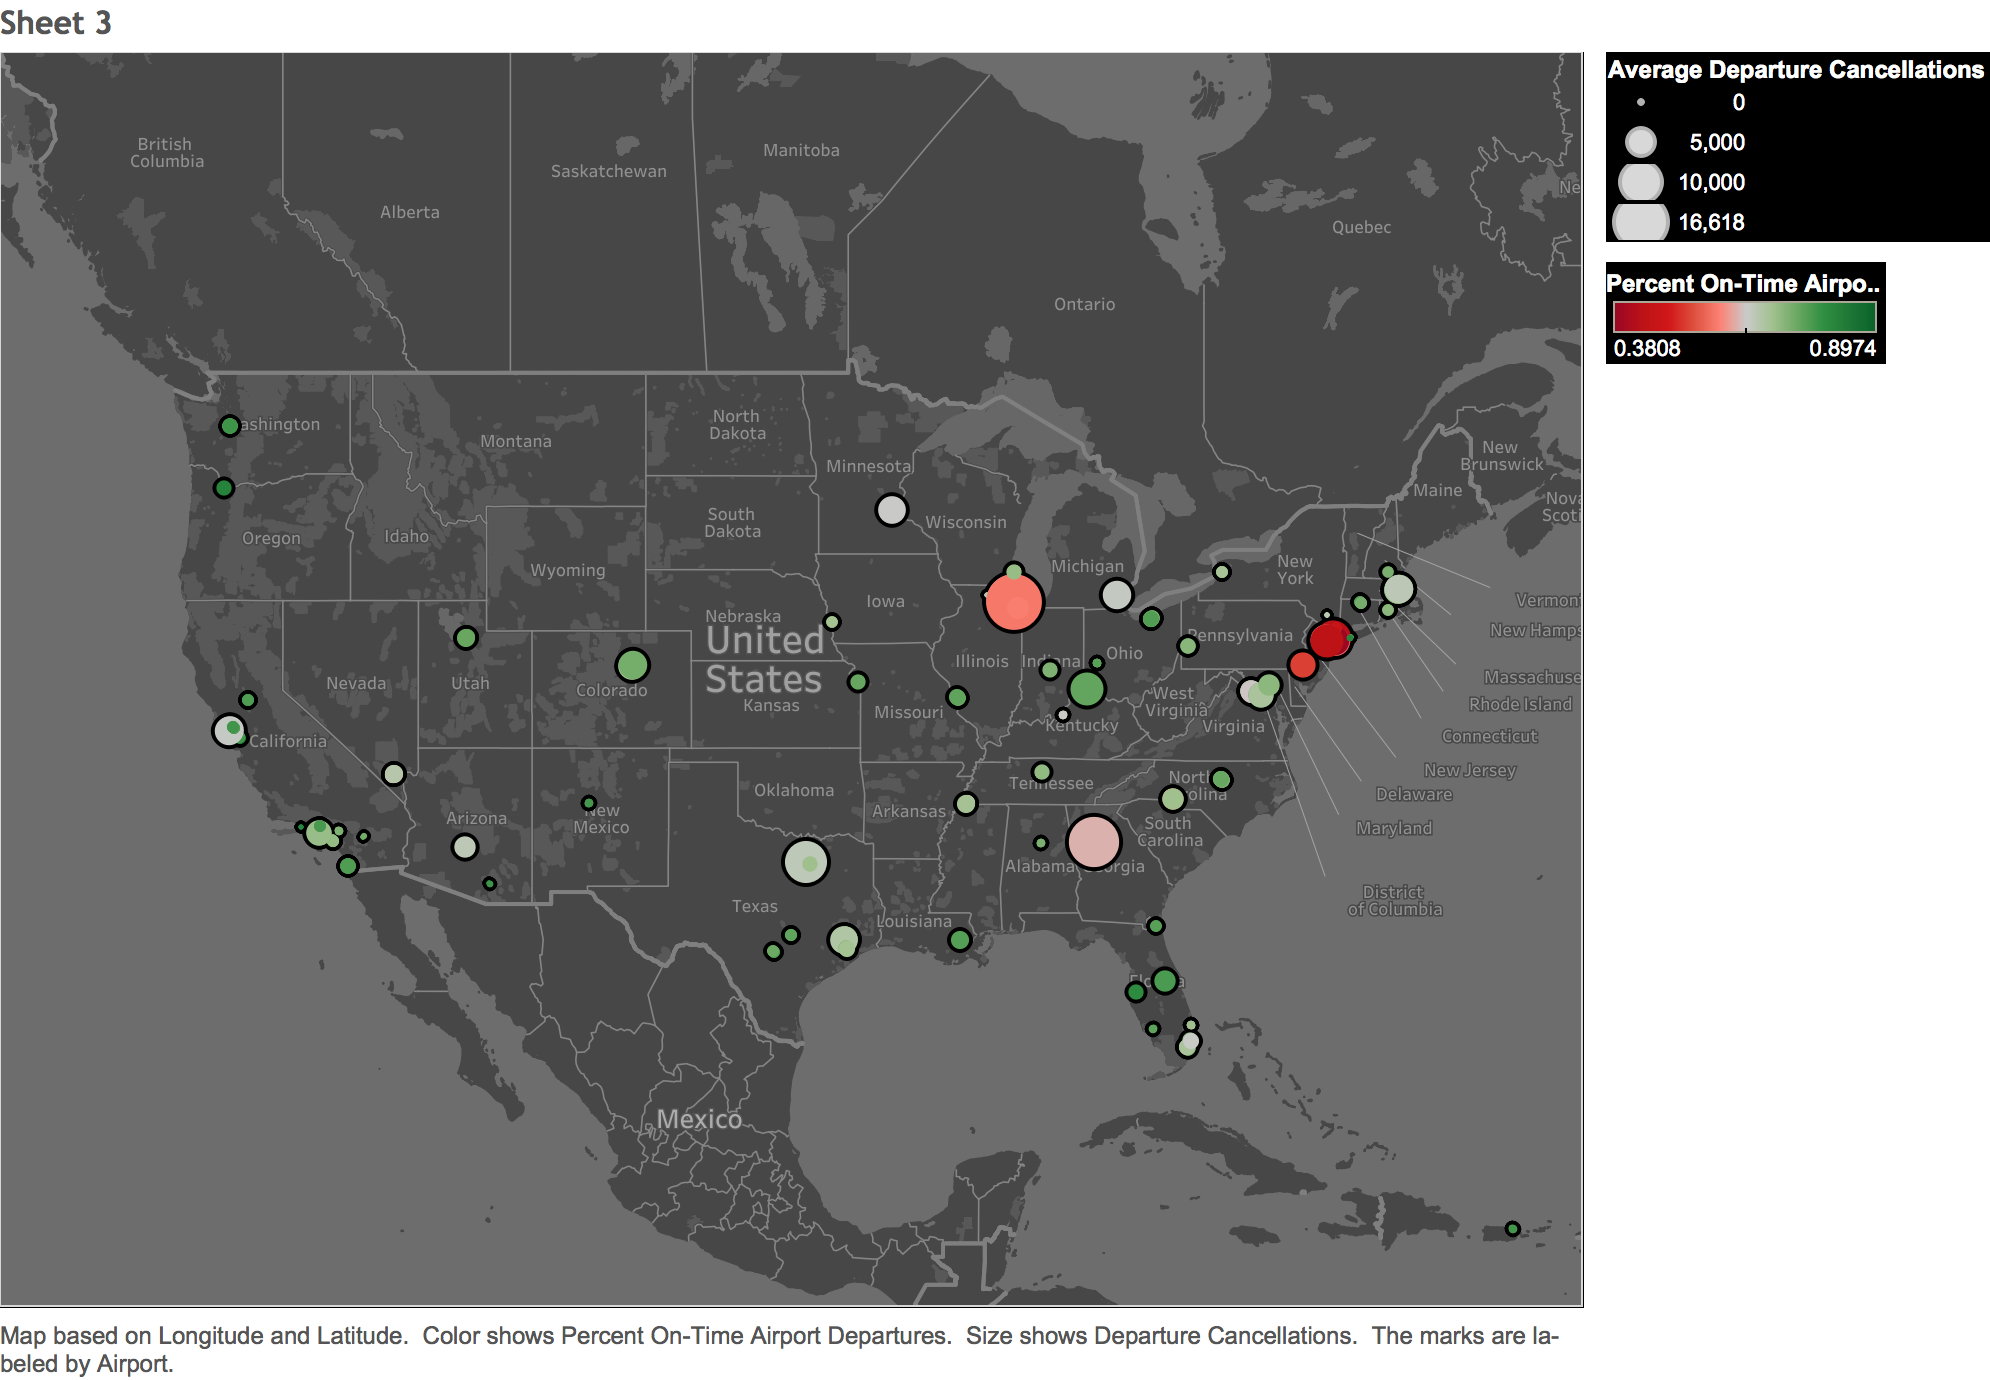

In [34]:
Image("assets/project7map.png", width=1200)

In [35]:
df.dtypes

airport                                object
year                                    int64
departures for metric computation       int64
arrivals for metric computation         int64
percent on-time gate departures       float64
percent on-time airport departures    float64
percent on-time gate arrivals         float64
average_gate_departure_delay          float64
average_taxi_out_time                 float64
average taxi out delay                float64
average airport departure delay       float64
average airborne delay                float64
average taxi in delay                 float64
average block delay                   float64
average gate arrival delay            float64
Airport                                object
Year                                  float64
Departure Cancellations               float64
Arrival Cancellations                 float64
Departure Diversions                  float64
Arrival Diversions                    float64
Key                               

In [36]:
for col in df.columns:
    print col, len(df[col].unique())

airport 74
year 11
departures for metric computation 795
arrivals for metric computation 799
percent on-time gate departures 620
percent on-time airport departures 686
percent on-time gate arrivals 630
average_gate_departure_delay 561
average_taxi_out_time 568
average taxi out delay 419
average airport departure delay 599
average airborne delay 348
average taxi in delay 270
average block delay 326
average gate arrival delay 554
Airport 74
Year 11
Departure Cancellations 672
Arrival Cancellations 655
Departure Diversions 353
Arrival Diversions 340
Key 74
LocID 74
AP_NAME 74
ALIAS 74
Facility Type 1
FAA REGION 9
COUNTY 63
CITY 69
STATE 36
AP Type 2
Latitude 74
Longitude 74
Boundary Data Available 1


In [37]:
df.columns

Index([u'airport', u'year', u'departures for metric computation',
       u'arrivals for metric computation', u'percent on-time gate departures',
       u'percent on-time airport departures', u'percent on-time gate arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average taxi out delay', u'average airport departure delay',
       u'average airborne delay', u'average taxi in delay',
       u'average block delay', u'average gate arrival delay', u'Airport',
       u'Year', u'Departure Cancellations', u'Arrival Cancellations',
       u'Departure Diversions', u'Arrival Diversions', u'Key', u'LocID',
       u'AP_NAME', u'ALIAS', u'Facility Type', u'FAA REGION', u'COUNTY',
       u'CITY', u'STATE', u'AP Type', u'Latitude', u'Longitude',
       u'Boundary Data Available'],
      dtype='object')

In [38]:
df.head(2)

airport  year  departures for metric computation  \
0     SJU  2014                              43671   
1     SJU  2013                              42902   

   arrivals for metric computation  percent on-time gate departures  \
0                            42965                           0.8056   
1                            42175                           0.8058   

   percent on-time airport departures  percent on-time gate arrivals  \
0                              0.7784                         0.7815   
1                              0.7808                         0.7840   

   average_gate_departure_delay  average_taxi_out_time  \
0                         11.71                  12.89   
1                         12.31                  13.56   

   average taxi out delay           ...             \
0                    1.88           ...              
1                    2.20           ...              

                                 ALIAS  Facility Type  FAA REGION  COUNTY  \
0  Aeropuerto Int'l Luis Muï¿½oz Marin        Airport         ASO  #NAME?   
1  Aeropuerto Int'l Luis Muï¿½oz Marin        Airport         ASO  #NAME?   

       CITY STATE                 AP Type   Latitude  Longitude  \
0  SAN JUAN    PR  Federalized/Commercial  18.439295 -66.002004   
1  SAN JUAN    PR  Federalized/Commercial  18.439295 -66.002004   

   Boundary Data Available  
0                      Yes  
1                      Yes  

[2 rows x 34 columns]

In [39]:
all(df.airport == df.Airport)

True

In [40]:
#actually not a lot of categorical data that is not location based. 
#Airport/airport will be the target, City / County / State are close to 1 to 1 to airports so no point including
#Facility Type / Boundary Data only have 1 value so no information to be gained.


catcols = df.columns[df.dtypes == object].drop(["LocID", "AP_NAME", "Airport", "airport", "Facility Type", 
                                                "ALIAS",  "Boundary Data Available", "STATE", "CITY", "COUNTY"])

catcols

Index([u'FAA REGION', u'AP Type'], dtype='object')

In [41]:
dummies = pd.get_dummies(df[catcols], prefix = "dummy", drop_first = 1)
dummies.head()

dummy_ACE  dummy_AEA  dummy_AGL  dummy_ANE  dummy_ANM  dummy_ASO  \
0        0.0        0.0        0.0        0.0        0.0        1.0   
1        0.0        0.0        0.0        0.0        0.0        1.0   
2        0.0        0.0        0.0        0.0        0.0        1.0   
3        0.0        0.0        0.0        0.0        0.0        1.0   
4        0.0        0.0        0.0        0.0        0.0        1.0   

   dummy_ASW  dummy_AWP  dummy_Public Use  
0        0.0        0.0               0.0  
1        0.0        0.0               0.0  
2        0.0        0.0               0.0  
3        0.0        0.0               0.0  
4        0.0        0.0               0.0

#### 3.2 Format and Clean the Data

In [42]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

rs = RobustScaler()
stand_num_cols = pd.DataFrame(rs.fit_transform(df[num_cols]), columns = num_cols)
stand_num_cols.head()

percent on-time gate departures  percent on-time airport departures  \
0                         0.373264                            0.466422   
1                         0.376736                            0.495726   
2                         1.000000                            1.008547   
3                         0.586806                            0.649573   
4                         0.218750                            0.504274   

   percent on-time gate arrivals  average_gate_departure_delay  \
0                       0.198377                     -0.218997   
1                       0.243463                     -0.060686   
2                       0.858431                     -0.788918   
3                       0.349865                     -0.443272   
4                       0.025248                     -0.087071   

   average_taxi_out_time  average taxi out delay  \
0              -0.011710               -0.609375   
1               0.145199               -0.442708   
2               0.049180               -0.640625   
3               0.067916               -0.567708   
4               0.023419               -0.864583   

   average airport departure delay  average airborne delay  \
0                        -0.428725               -0.534653   
1                        -0.345123               -0.554455   
2                        -0.981779               -0.798680   
3                        -0.655949               -0.772277   
4                        -0.456592               -0.640264   

   average taxi in delay  average block delay  average gate arrival delay  \
0              -0.150538            -0.166667                   -0.049113   
1               0.290323            -0.225000                   -0.002729   
2               0.204301            -0.200000                   -0.635744   
3               0.462366             0.450000                   -0.188267   
4               0.193548             0.333333                    0.117326   

   Departure Cancellations  Arrival Cancellations  Departure Diversions  \
0                -0.343764              -0.335642             -0.222857   
1                -0.478625              -0.455397             -0.262857   
2                -0.437197              -0.417108             -0.280000   
3                -0.379022              -0.368228             -0.057143   
4                -0.363156              -0.363340             -0.165714   

   Arrival Diversions  
0           -0.355705  
1           -0.134228  
2           -0.288591  
3           -0.194631  
4           -0.261745

In [43]:
target.head(2)

0    SJU
1    SJU
Name: airport, dtype: object

In [44]:
le = LabelEncoder()
target_enc = le.fit_transform(target)
target_enc[:2]

array([66, 66])

Looking at density plots and histograms as shown above gives the idea that the distributions look roughly gaussian. But the actual normaltest statistic which does a Chi square test rejects the hypothesis that the data is normally distributed. Perhaps if the sample was larger we would see that the distribution is indeed normal but given the relatively small sample the p-values are very small which means that the distribution did not come from a normal one.

In [45]:
from scipy.stats.mstats import normaltest

for col in num_cols:
    print col
    print normaltest(df[col], axis = 0)
    print

percent on-time gate departures
NormaltestResult(statistic=126.79779757271547, pvalue=2.9255538625474211e-28)

percent on-time airport departures
NormaltestResult(statistic=139.0504605018304, pvalue=6.3911078888648059e-31)

percent on-time gate arrivals
NormaltestResult(statistic=124.98299390362925, pvalue=7.2491603764747067e-28)

average_gate_departure_delay
NormaltestResult(statistic=45.271711496764311, pvalue=1.4769736771539398e-10)

average_taxi_out_time
NormaltestResult(statistic=295.08863972444874, pvalue=8.3621133013037698e-65)

average taxi out delay
NormaltestResult(statistic=462.20657534404324, pvalue=4.296525704342947e-101)

average airport departure delay
NormaltestResult(statistic=194.8153297466541, pvalue=4.9703692116959458e-43)

average airborne delay
NormaltestResult(statistic=142.94812842981776, pvalue=9.103498233363152e-32)

average taxi in delay
NormaltestResult(statistic=254.26970343675279, pvalue=6.1099188359508099e-56)

average block delay
NormaltestResult(statist

In [46]:
target_enc[:2]

array([66, 66])

In [47]:
trans_data = stand_num_cols.join(dummies)
trans_data.head(2)                            #transformed data

percent on-time gate departures  percent on-time airport departures  \
0                         0.373264                            0.466422   
1                         0.376736                            0.495726   

   percent on-time gate arrivals  average_gate_departure_delay  \
0                       0.198377                     -0.218997   
1                       0.243463                     -0.060686   

   average_taxi_out_time  average taxi out delay  \
0              -0.011710               -0.609375   
1               0.145199               -0.442708   

   average airport departure delay  average airborne delay  \
0                        -0.428725               -0.534653   
1                        -0.345123               -0.554455   

   average taxi in delay  average block delay        ...         \
0              -0.150538            -0.166667        ...          
1               0.290323            -0.225000        ...          

   Arrival Diversions  dummy_ACE  dummy_AEA  dummy_AGL  dummy_ANE  dummy_ANM  \
0           -0.355705        0.0        0.0        0.0        0.0        0.0   
1           -0.134228        0.0        0.0        0.0        0.0        0.0   

   dummy_ASO  dummy_ASW  dummy_AWP  dummy_Public Use  
0        1.0        0.0        0.0               0.0  
1        1.0        0.0        0.0               0.0  

[2 rows x 24 columns]

In [48]:
from sklearn.decomposition import FactorAnalysis, PCA

pca = PCA(n_components=10)

pca.fit(trans_data)

PCA(copy=True, n_components=10, whiten=False)

In [49]:
var = pca.explained_variance_ratio_
list(var)

[0.57119172456711043,
 0.19418924775620358,
 0.069379824856990457,
 0.04037736369212451,
 0.026020849641222171,
 0.019536465443826288,
 0.015241994217553453,
 0.011475944323014128,
 0.0088883276000496659,
 0.0079603340393630002]

In [50]:
for index, item in enumerate(np.cumsum(var)):
    print index+1, item

1 0.571191724567
2 0.765380972323
3 0.83476079718
4 0.875138160872
5 0.901159010514
6 0.920695475957
7 0.935937470175
8 0.947413414498
9 0.956301742098
10 0.964262076137


Looks like the first 5 principal components explain about 90% of the total variance whereas if we reduce it to 3D we can explain and actually graph a representation that would contain 83% of the variance. To simplify, I will look at the first 3 and analyse them in the following section after I add a little formatting to it.

In [51]:
np.shape(trans_data)

(799, 24)

In [52]:
components = pd.DataFrame(pca.components_[:5].T, index = trans_data.columns)


#i could not find a sort by absolute value function so i worked around using .get method below to present


for i in range(3):
    rank = abs(components[i]).sort_values(ascending = 0) \
    * np.sign(components[i].get(abs(components[i]).sort_values(ascending = 0).keys())) 
                                                                                       # sort the absolute values 
                                                                                       # get the corresponding key
                                                                                       # and multiply by sign of the 
                                                                                       # value from non -abs series
    
    print "Principal Component" , i+1
    print
    print rank[:10]
    print "\n"

Principal Component 1

Departure Cancellations               0.456256
Arrival Cancellations                 0.451601
Arrival Diversions                    0.401298
average taxi out delay                0.296764
Departure Diversions                  0.246095
average taxi in delay                 0.232608
average airport departure delay       0.213051
average_taxi_out_time                 0.208717
percent on-time airport departures   -0.203459
average block delay                   0.148180
Name: 0, dtype: float64


Principal Component 2

percent on-time gate arrivals        -0.405016
percent on-time gate departures      -0.360920
average gate arrival delay            0.349797
average_gate_departure_delay          0.319051
average airport departure delay       0.310904
percent on-time airport departures   -0.306935
Arrival Diversions                   -0.246209
Arrival Cancellations                -0.243713
Departure Cancellations              -0.227337
Departure Diversions               

In [53]:
i =0
pca1 = abs(components[i]).sort_values(ascending = 0)* \
np.sign(components[i].get(abs(components[i]).sort_values(ascending = 0).keys()))

pca1[:10]

Departure Cancellations               0.456256
Arrival Cancellations                 0.451601
Arrival Diversions                    0.401298
average taxi out delay                0.296764
Departure Diversions                  0.246095
average taxi in delay                 0.232608
average airport departure delay       0.213051
average_taxi_out_time                 0.208717
percent on-time airport departures   -0.203459
average block delay                   0.148180
Name: 0, dtype: float64

PCA1: the first principal component is most positively correlated with Departure Cancellations, Arrival Cancellations and Arrival Diversions. That means that if one of the variables increases, the other ones tend to as well which makes sense since cancellations would likely affect both incoming and outgoing flights if, for example, weather conditions adversely affected the airport.

In [54]:
i =1
pca2 = abs(components[i]).sort_values(ascending = 0)* \
np.sign(components[i].get(abs(components[i]).sort_values(ascending = 0).keys()))

pca2[:10]

percent on-time gate arrivals        -0.405016
percent on-time gate departures      -0.360920
average gate arrival delay            0.349797
average_gate_departure_delay          0.319051
average airport departure delay       0.310904
percent on-time airport departures   -0.306935
Arrival Diversions                   -0.246209
Arrival Cancellations                -0.243713
Departure Cancellations              -0.227337
Departure Diversions                 -0.202418
Name: 1, dtype: float64

PCA2: the second principal component is negatively related to on-time gate departures and arrivals and positively correlate with departure and arrival delays. Given how correlated some of these variables are, this PCA combines the logical variables where perecentage on time decreases as delays go up and so on...

In [55]:
i =2
pca2 = abs(components[i]).sort_values(ascending = 0)* \
np.sign(components[i].get(abs(components[i]).sort_values(ascending = 0).keys()))

pca2[:10]

average taxi out delay            -0.566777
average_taxi_out_time             -0.433023
percent on-time gate departures   -0.317001
Arrival Cancellations              0.282696
Departure Cancellations            0.281281
average airborne delay            -0.279172
average_gate_departure_delay       0.227842
percent on-time gate arrivals     -0.183099
average block delay               -0.163428
average taxi in delay             -0.121369
Name: 2, dtype: float64

PCA3: the third principal component captures the relationship between taxi delays and and taxi times as they relate to on-time gate departures. Here an interesting aspect is that there is some correlation between taxi out delay and taxi out time. So the delay decreases when the taxi out time is less which makes sense.

Next I will look to see if the airports cluster well based on this data. 

In [56]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering 
from sklearn.metrics import silhouette_score, silhouette_samples

Let me try a DBSCAN clustering algorithm and a hierarchical algorith as well to see if the results are decent.

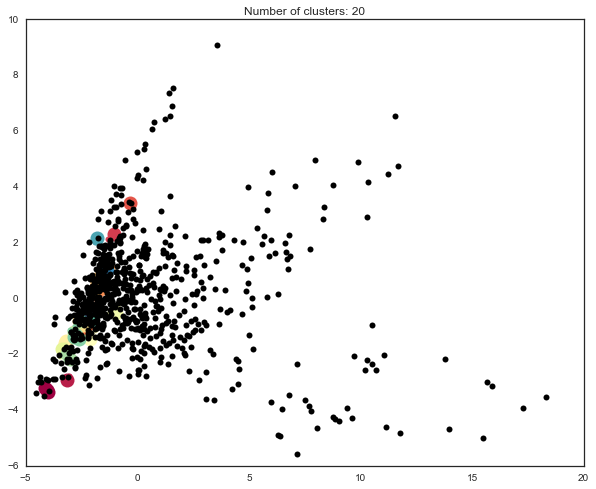

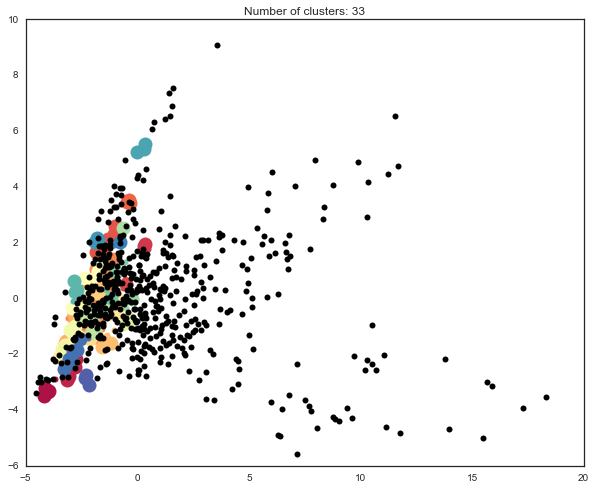

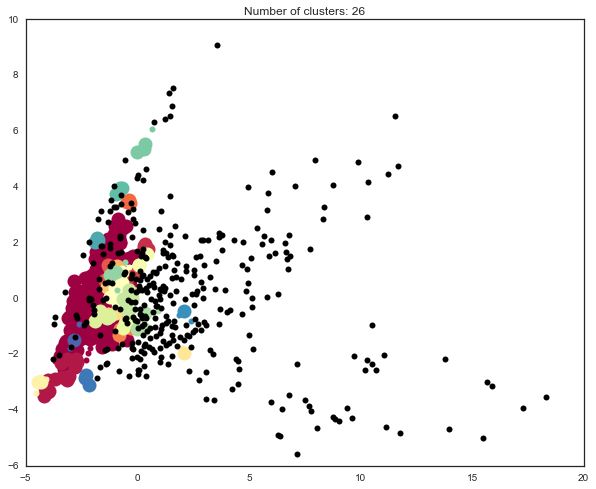

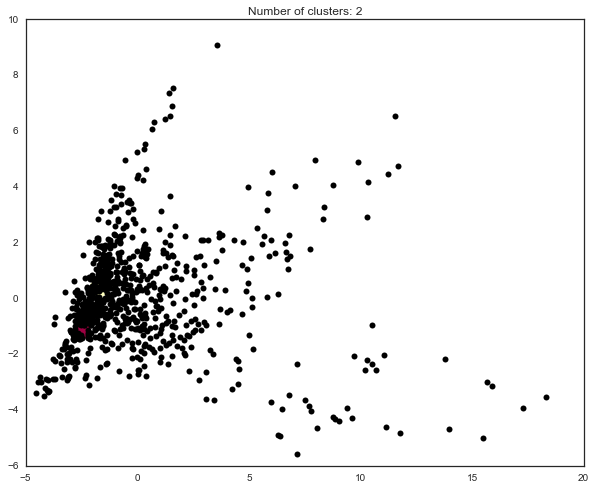

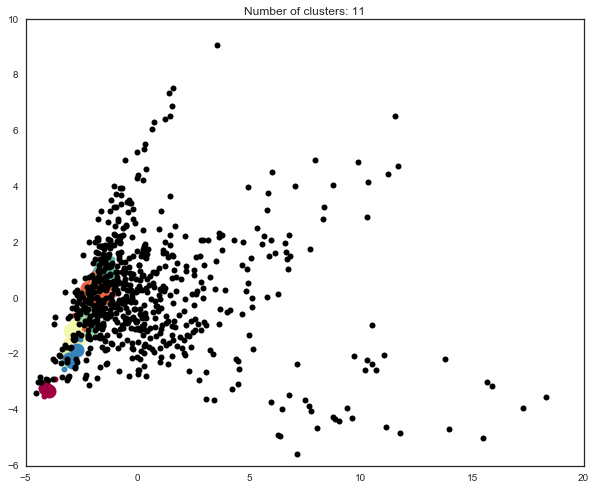

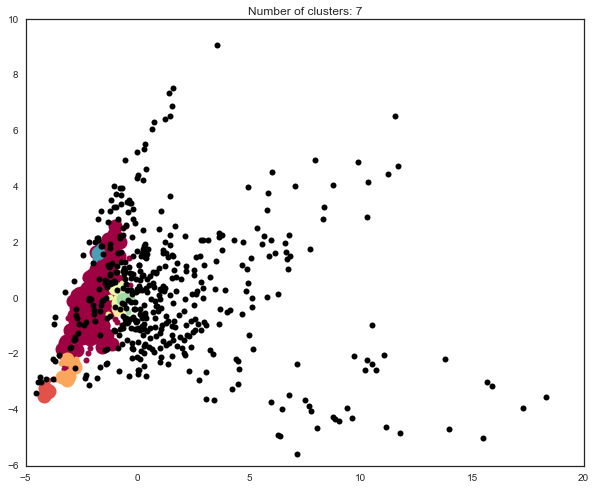

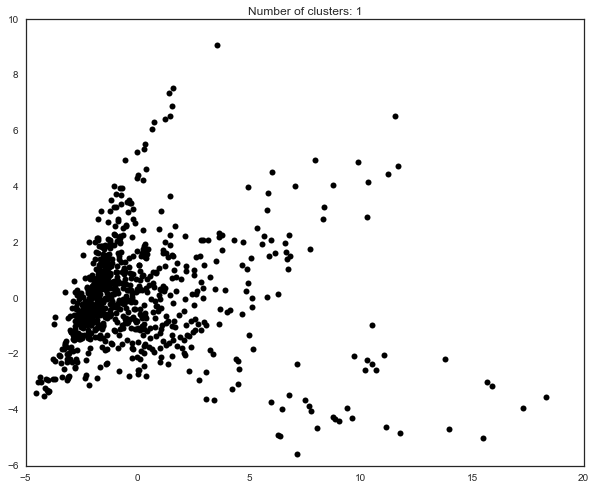

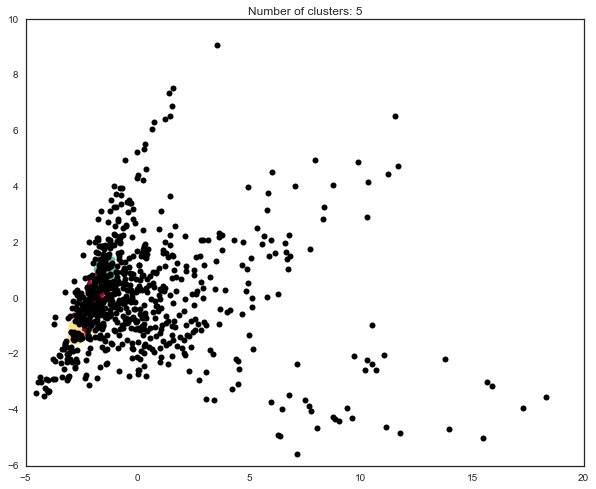

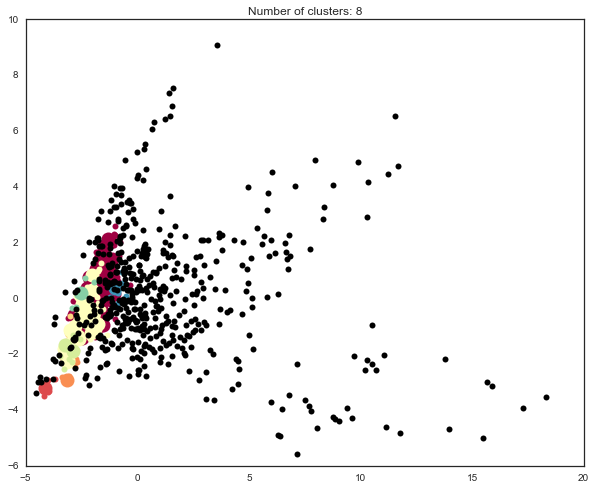

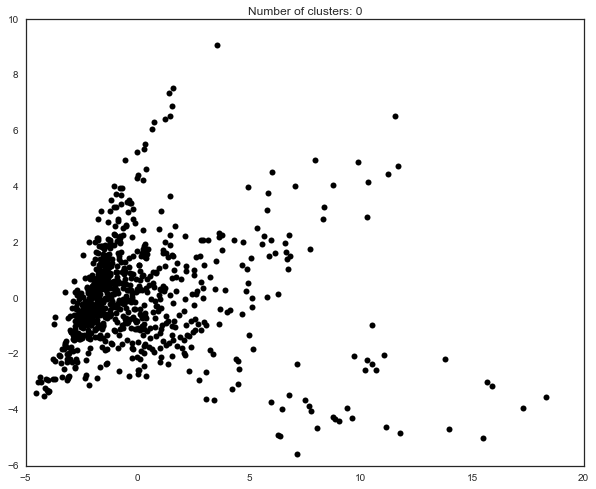

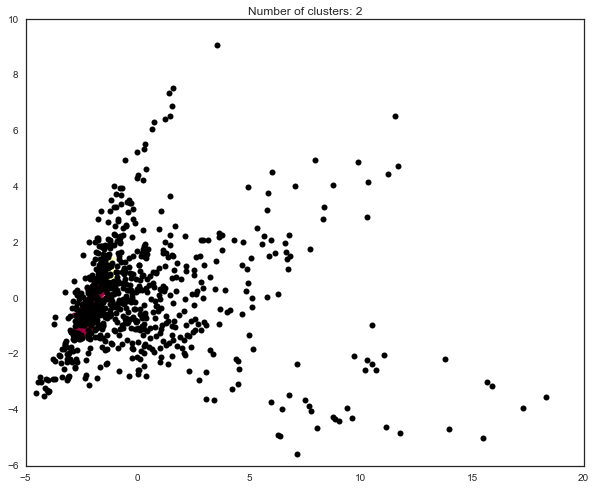

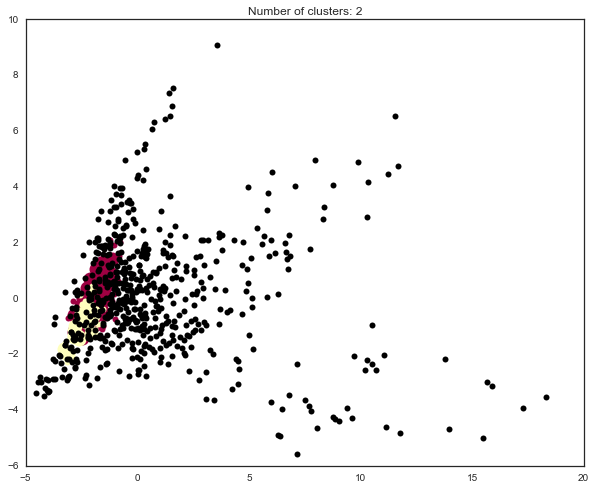

In [63]:
X = pca.fit_transform(trans_data)
eps = [.5, .7, .9]
samples = [3, 5, 7, 10]

for i in samples:
    for j in eps:


        db = DBSCAN(min_samples= i, eps = j)

        db.fit(X)

        len(np.unique(db.labels_))

        fig = plt.figure(figsize=(10,8))

        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

        # Black removed and is used for noise instead.
        unique_labels = set(labels)
        colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = 'k'

            class_member_mask = (labels == k)

            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                     markeredgecolor='k', markersize=14)

            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                     markeredgecolor='k', markersize=6)

        plt.title('Number of clusters: %d' % n_clusters_)
        plt.show()



Just by visual inspection it doesn't look like DBSCAN is working particularly well for this data, the majority of the  the data is being called an outlier even using different values of min samples and epsilon. For practice, I can try a different algorithm here and use Hirearchical clustering.

('For n_clusters =', 2, 'The average silhouette_score is :', 0.5871701582691079)


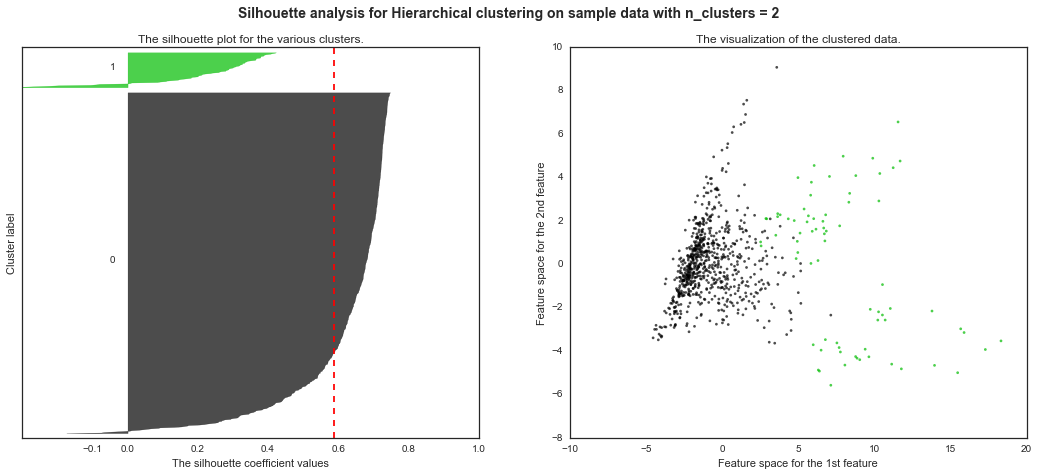

('For n_clusters =', 3, 'The average silhouette_score is :', 0.25540203367634606)


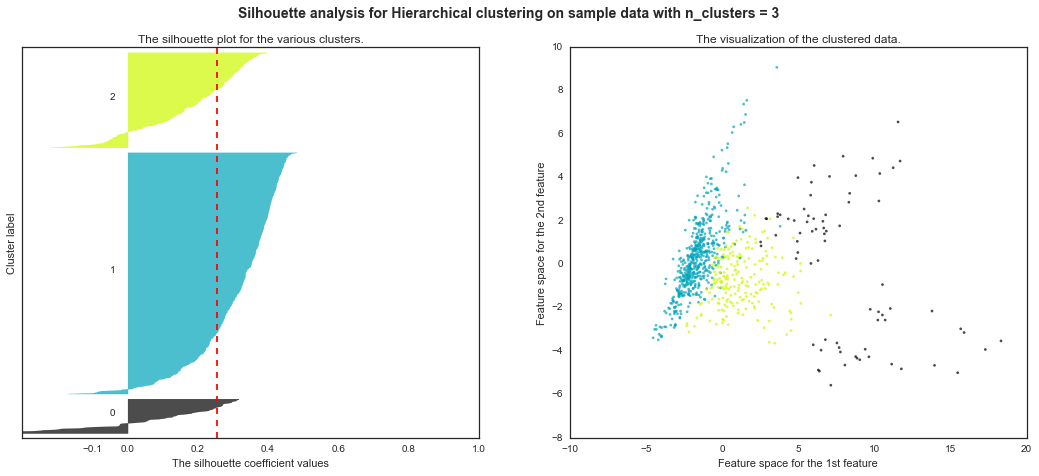

('For n_clusters =', 4, 'The average silhouette_score is :', 0.27571526657385348)


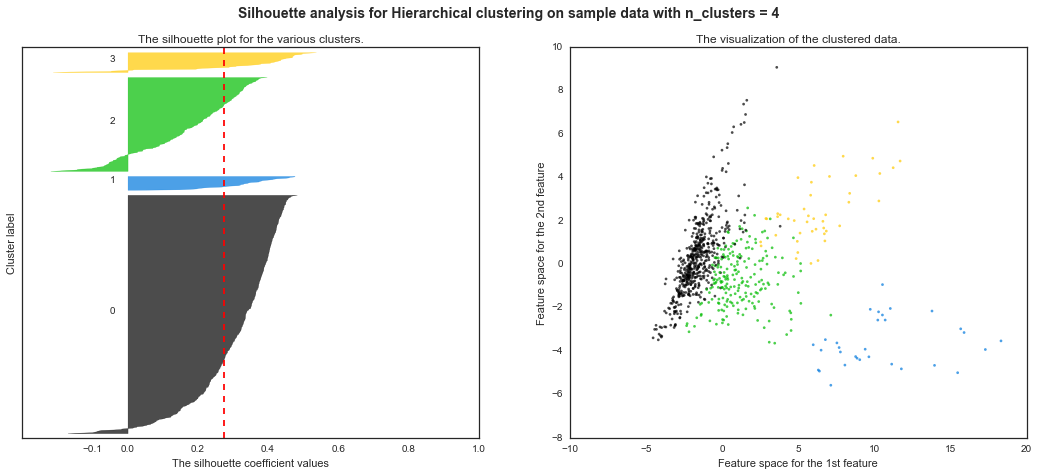

('For n_clusters =', 5, 'The average silhouette_score is :', 0.27067657173902404)


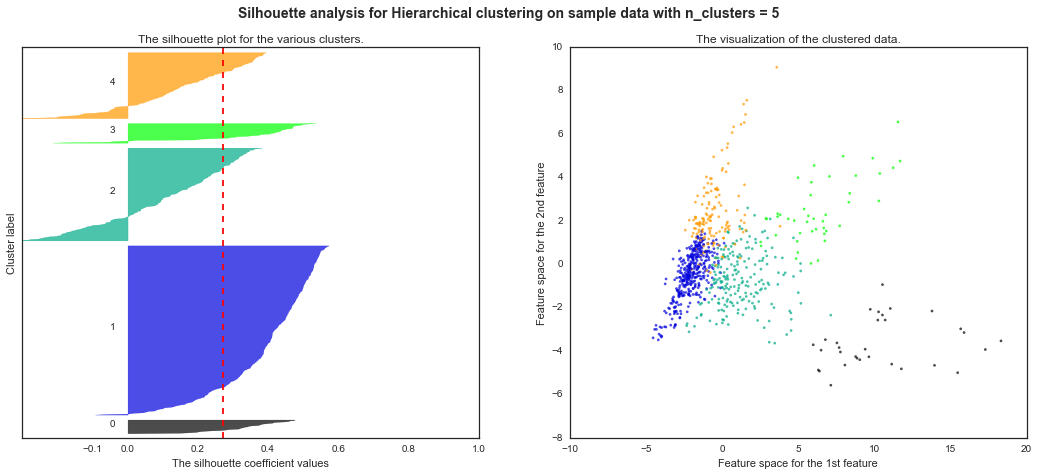

('For n_clusters =', 6, 'The average silhouette_score is :', 0.2726164833782922)


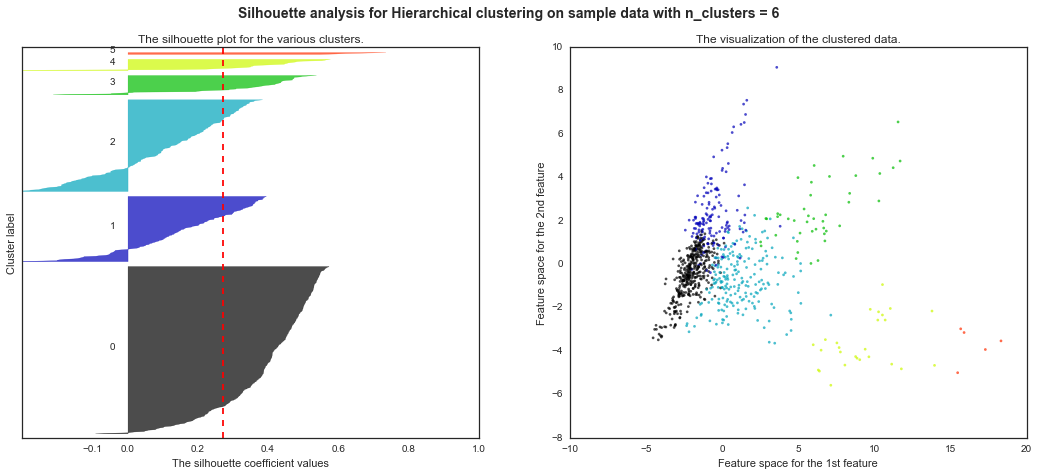

('For n_clusters =', 7, 'The average silhouette_score is :', 0.19408163709077891)


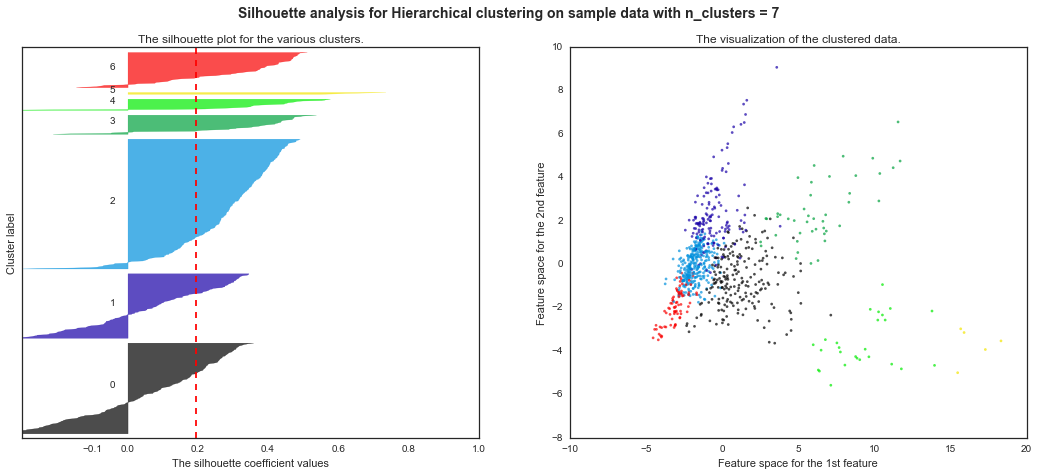

In [64]:
X = pca.fit_transform(trans_data)

ac = AgglomerativeClustering()

range_n_clusters = [2, 3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-.3, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)


    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for Hierarchical clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

 
 #### It looks a little better here but let me also try Kmeans to compare and see if the silhouette scores are higher.

('For n_clusters =', 2, 'The average silhouette_score is :', 0.57078262980647176)


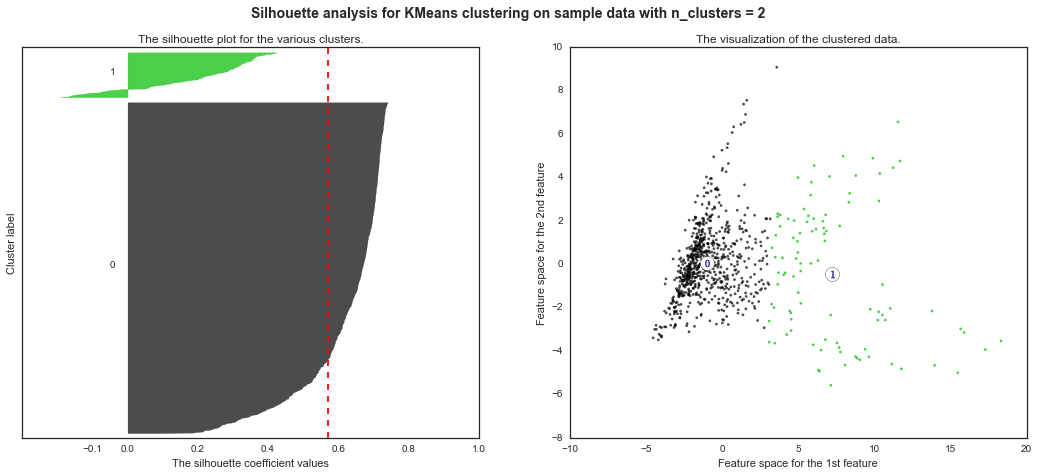

('For n_clusters =', 3, 'The average silhouette_score is :', 0.43439738270528827)


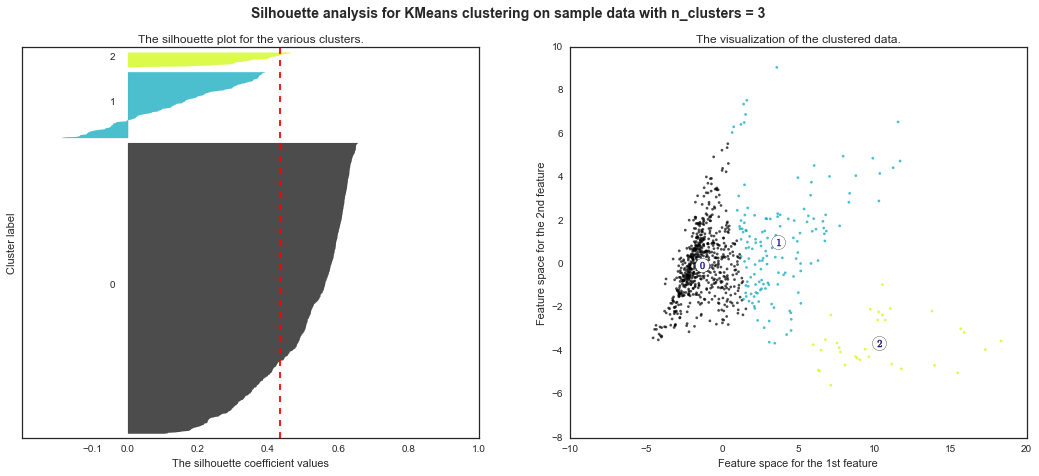

('For n_clusters =', 4, 'The average silhouette_score is :', 0.24547222877680169)


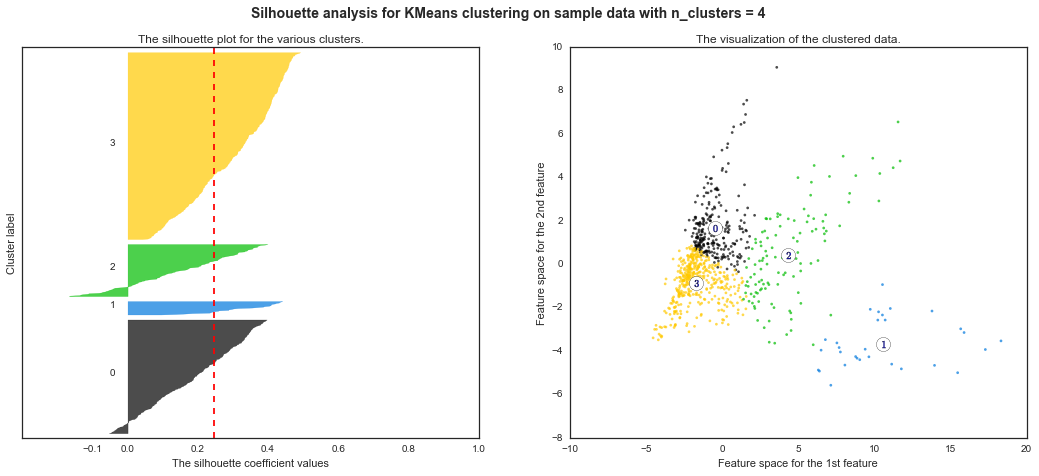

('For n_clusters =', 5, 'The average silhouette_score is :', 0.27069251745609429)


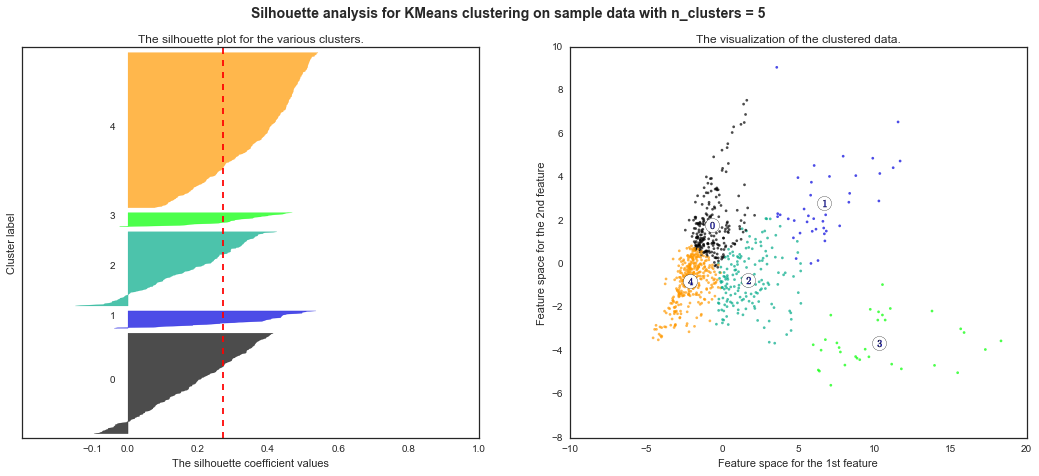

('For n_clusters =', 6, 'The average silhouette_score is :', 0.2840932245574237)


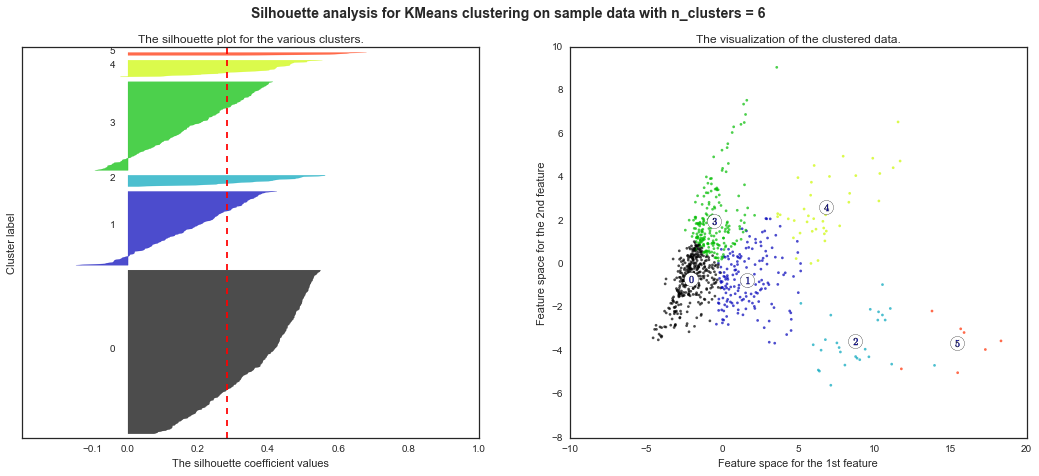

('For n_clusters =', 7, 'The average silhouette_score is :', 0.2349954927347383)


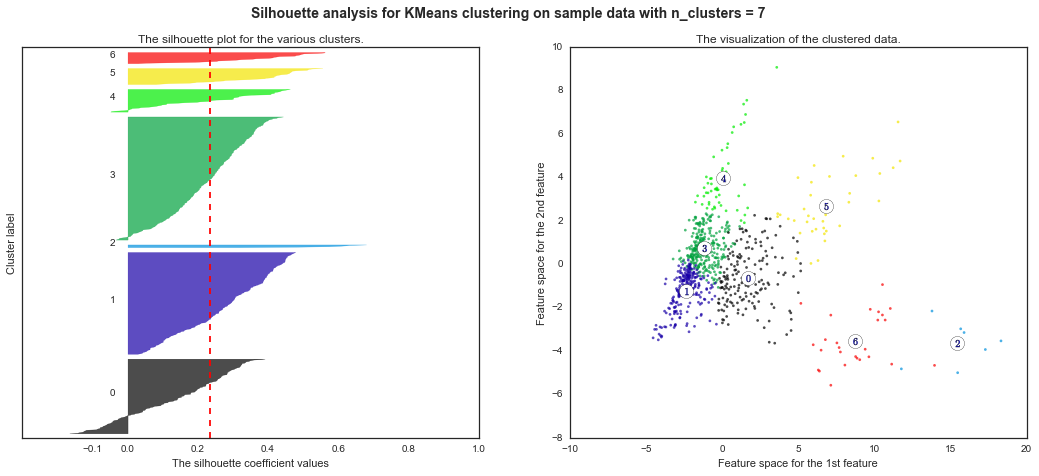

In [65]:
#I am going to try the graphical representation of the silhouette scores for Kmeans clustering using differnt Ks

X = pca.fit_transform(trans_data)

range_n_clusters = [2, 3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-.3, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

# Analysis / Reccomendations

Looks like for 6 clusters k-means is able to find decent clusters so we will use that for the analysis.

In [67]:
n_clusters = 6
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
df["cluster_labels"] = clusterer.fit_predict(X)



In [72]:
df.cluster_labels.value_counts()

0    365
3    198
1    165
4     38
2     26
5      7
Name: cluster_labels, dtype: int64

In [125]:
df[(df.cluster_labels == 4)|(df.cluster_labels == 5)][["airport", "CITY", "FAA REGION"]].drop_duplicates()



airport          CITY FAA REGION
240     ATL       ATLANTA        ASO
523     PHL  PHILADELPHIA        AEA
551     JFK      NEW YORK        AEA
562     EWR        NEWARK        AEA
573     LGA      NEW YORK        AEA
683     ORD       CHICAGO        AGL
718     BOS        BOSTON        ANE

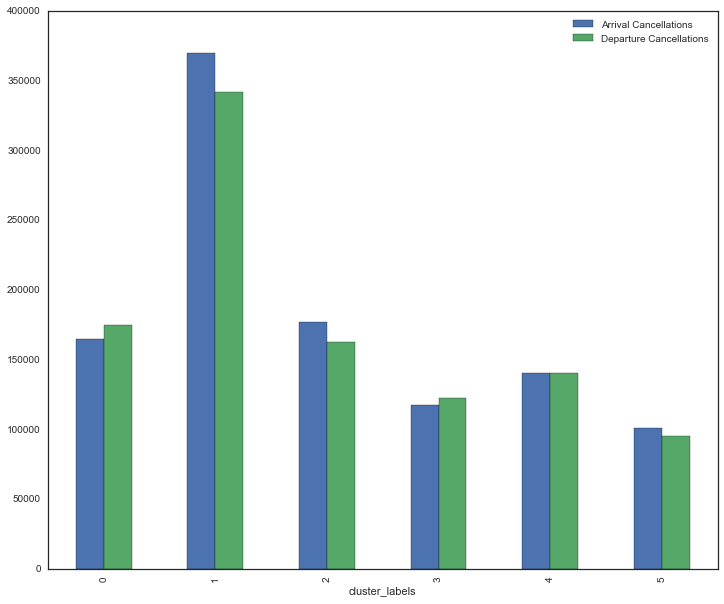

In [119]:

cancels_by_cluster = df.pivot_table(values = ["Departure Cancellations", "Arrival Cancellations"], 
                                    index = ["cluster_labels"], aggfunc = "sum")
cancels_by_cluster.plot(kind = "bar", figsize = (12,10));


In [123]:
print cancels_by_cluster["Arrival Cancellations"] / sum(cancels_by_cluster["Arrival Cancellations"])

print cancels_by_cluster["Departure Cancellations"] / sum(cancels_by_cluster["Departure Cancellations"])

cluster_labels
0    0.153628
1    0.345156
2    0.165473
3    0.110103
4    0.131025
5    0.094615
Name: Arrival Cancellations, dtype: float64
cluster_labels
0    0.168766
1    0.329574
2    0.156504
3    0.118184
4    0.135214
5    0.091757
Name: Departure Cancellations, dtype: float64


In [124]:
df.groupby("cluster_labels").mean()[num_cols]

percent on-time gate departures  \
cluster_labels                                    
0                                      0.810059   
1                                      0.788780   
2                                      0.766515   
3                                      0.725732   
4                                      0.739003   
5                                      0.713186   

                percent on-time airport departures  \
cluster_labels                                       
0                                         0.781664   
1                                         0.710687   
2                                         0.671669   
3                                         0.687133   
4                                         0.539989   
5                                         0.604729   

                percent on-time gate arrivals  average_gate_departure_delay  \
cluster_labels                                                                
0                                    0.790207                     10.986658   
1                                    0.784945                     12.337394   
2                                    0.782200                     13.948077   
3                                    0.720924                     15.753434   
4                                    0.701542                     16.898947   
5                                    0.720571                     18.502857   

                average_taxi_out_time  average taxi out delay  \
cluster_labels                                                  
0                           11.771753                2.493945   
1                           16.506485                4.930788   
2                           17.725769                6.014231   
3                           12.726111                2.917576   
4                           25.097632               11.426842   
5                           18.545714                7.258571   

                average airport departure delay  average airborne delay  \
cluster_labels                                                            
0                                     12.652986                2.303726   
1                                     16.253515                3.557636   
2                                     18.930385                2.836923   
3                                     17.953737                2.818182   
4                                     27.014474                5.620789   
5                                     24.764286                3.475714   

                average taxi in delay  average block delay  \
cluster_labels                                               
0                            0.964329             2.752685   
1                            2.002727             3.572606   
2                            3.867308             4.018462   
3                            1.123081             3.572172   
4                            2.625263             4.935789   
5                            3.542857             5.118571   

                average gate arrival delay  Departure Cancellations  \
cluster_labels                                                        
0                                11.638712               480.013699   
1                                12.721818              2073.624242   
2                                14.050385              6249.038462   
3                                15.801768               619.661616   
4                                19.744737              3694.026316   
5                                19.718571             13608.285714   

                Arrival Cancellations  Departure Diversions  \
cluster_labels                                                
0                          451.000000             91.531507   
1                         2241.448485            316.078788   
2                         6819.500000            735.000000   
3                          595.843434 

Clusters 4 and 5 account for over 20% of all cancellations in the study period. They are all concentrated in 7 airports mostly in the Northeast but also including Chicago and Atlanta. These clusters have much higher taxi out delays and taxi out times so this is an operational feature that can be investigated further where maybe some efficiency can be gained by aligning terminals and runways better etc. These clusters also have, on average higher airborne delay and also higher gate arrival delays. Overall this seems to suggest that the ariports are being used at levels higher than optimal capacity.

Cluster number 1 accounts for roughly 33% of all cancellations. However it actually a fairly large cluster and does not stand out in any particular operational facet given the factors considered. 

It appears that the airports in clusters 4 and 5 should be considered first and are the "low hanging fruit" yielded by this analysis. 


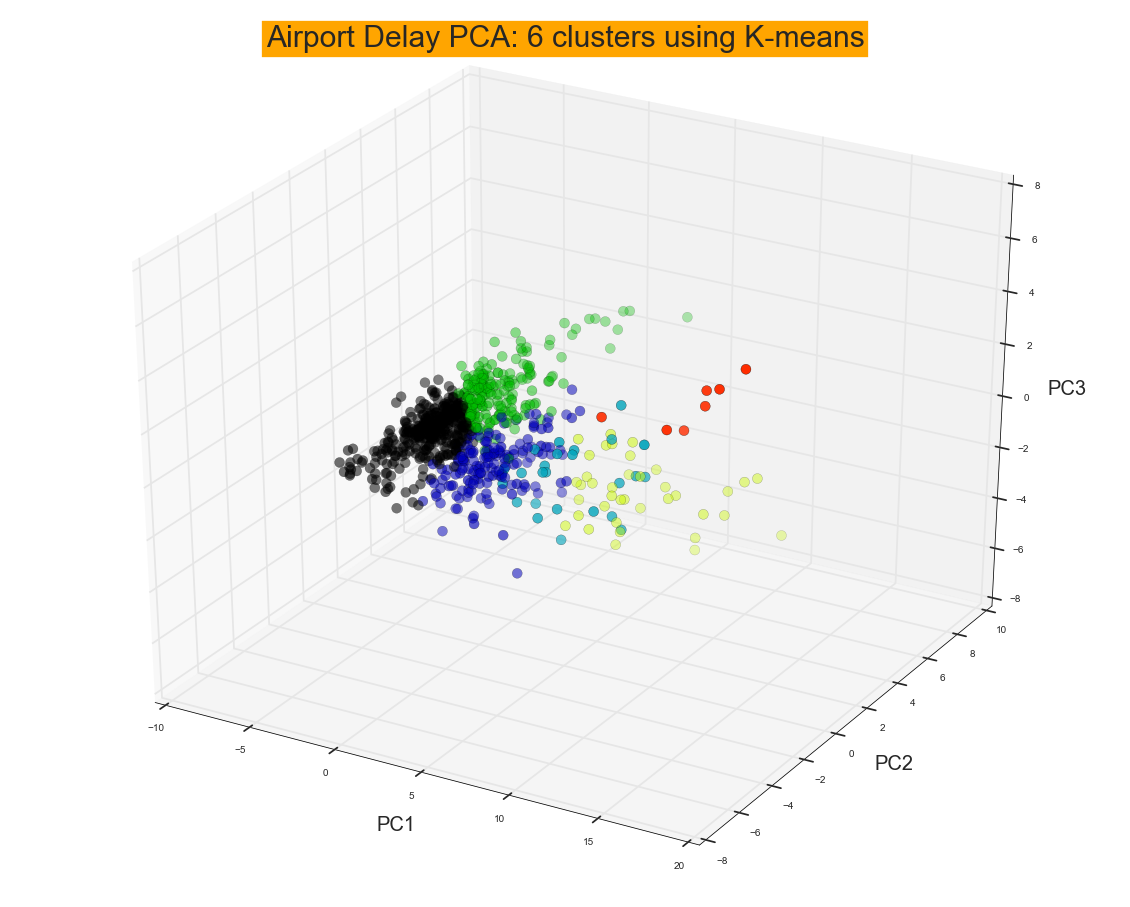

In [66]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

n_clusters = 6
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)



fig = plt.figure( figsize = (20,16))
ax = fig.add_subplot(111, projection='3d')

ax.set_title("Airport Delay PCA: {} clusters using K-means".format(n_clusters), size = 30, loc = "center")
ax.set_xlabel('PC1', labelpad= 20, size = 20)
ax.set_ylabel('PC2', labelpad= 20, size = 20)
ax.set_zlabel('PC3', labelpad= 20, size = 20)

ax.title.set_backgroundcolor("orange")
ax.title.set_position((.5,.95))


ax.scatter(X[:,0], X[:,1], X[:,2], s=100, c = plt.cm.spectral(cluster_labels.astype(float)/ n_clusters ))

plt.show();